<a href="https://colab.research.google.com/github/msyauqim/Implementasi-Convolutional-Neural-Network-sebagai-Sistem-Deteksi-Dini-Penyakit-Glaukoma/blob/main/Implementasi_Convolutional_Neural_Network_sebagai_Sistem_Deteksi_Dini_Penyakit_Glaukoma_pada_Citra_Fundus_Mata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Persiapan Lingkungan dan Dataset

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import os
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix

# Konstanta untuk model
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32
MODEL_FILENAME = 'cnn_glaukoma_detection.h5'

# --- Konfigurasi Path Google Drive ---
from google.colab import drive

print("Melakukan mounting Google Drive...")
drive.mount('/content/drive')

# DEFINISI PATH UTAMA DATA
path_utama = '/content/drive/MyDrive/project_akhir_comvis/ACRIMA/'

# Definisi Path untuk Data Latih, Validasi, dan Uji
TRAIN_DIR = os.path.join(path_utama, 'PARTITIONED', 'Training')
# VAL_DIR sekarang menunjuk ke direktori induk yang berisi subfolder 'gloucoma' dan 'normal'
VAL_DIR = os.path.join(path_utama, 'NOT_PARTITIONED')
TEST_DIR = os.path.join(path_utama, 'PARTITIONED', 'Testing') # Menambahkan path untuk data uji

print(f"Path Data Latih: {TRAIN_DIR}")
print(f"Path Data Validasi: {VAL_DIR}")
print(f"Path Data Uji: {TEST_DIR}")

Melakukan mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Path Data Latih: /content/drive/MyDrive/project_akhir_comvis/ACRIMA/PARTITIONED/Training
Path Data Validasi: /content/drive/MyDrive/project_akhir_comvis/ACRIMA/NOT_PARTITIONED
Path Data Uji: /content/drive/MyDrive/project_akhir_comvis/ACRIMA/PARTITIONED/Testing


2. Pre-processing dan Augmentasi Data

In [3]:
# 1. Image Data Generator dengan Augmentasi (untuk Data Latih)
# Tambahkan shear_range dan zoom_range yang sedikit lebih besar
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,      # Ditingkatkan dari 20
    width_shift_range=0.25, # Ditingkatkan dari 0.2
    height_shift_range=0.25,# Ditingkatkan dari 0.2
    shear_range=0.3,        # Ditingkatkan dari 0.2
    zoom_range=0.3,         # Ditingkatkan dari 0.2
    horizontal_flip=True,
    fill_mode='nearest'
)

# 2. Image Data Generator (Hanya Rescale untuk Data Validasi)
val_datagen = ImageDataGenerator(rescale=1./255)

# 3. Load Data dari Direktori
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary' # Klasifikasi 2 kategori (Normal dan Glaukoma)
)

validation_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

class_indices = train_generator.class_indices
print(f"Indeks Kelas: {class_indices}") # Contoh: {'Glaukoma': 0, 'Normal': 1}

Found 569 images belonging to 2 classes.
Found 705 images belonging to 2 classes.
Indeks Kelas: {'glaucoma': 0, 'normal': 1}


3. Definisi dan Pelatihan Model CNN

In [5]:
EPOCHS = 20 # Jumlah epoch pelatihan

# Inisialisasi Model CNN
model = Sequential([
    # Convolutional Layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Layer 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Layer 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flattening Layer
    Flatten(),

    # Fully Connected Layer
    Dense(512, activation='relu'),
    Dropout(0.5),

    # Output Layer (Sigmoid untuk klasifikasi binary)
    Dense(1, activation='sigmoid')
])

# Kompilasi Model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


# Pelatihan Model
print("\n--- Memulai Pelatihan Model ---")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

print("\n✅ Proses Pelatihan Selesai!")

# Simpan Model yang sudah dilatih
model.save(MODEL_FILENAME)
print(f"Model telah disimpan sebagai '{MODEL_FILENAME}' di sesi Colab.")

# --- Pindahkan model ke Google Drive agar tidak hilang (Opsional) ---
drive_save_path = os.path.join('/content/drive/MyDrive/project_akhir_comvis', MODEL_FILENAME)
model.save(drive_save_path)
print(f"Model juga disimpan ke Google Drive di: {drive_save_path}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)


--- Memulai Pelatihan Model ---
Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 288s 18s/step - accuracy: 0.5227 - loss: 0.7463 - val_accuracy: 0.7912 - val_loss: 0.4353
Epoch 2/20
 1/17 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7500 - loss: 0.4290

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 822ms/step - accuracy: 0.7500 - loss: 0.4290 - val_accuracy: 0.7415 - val_loss: 0.6032
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.7864 - loss: 0.4778 - val_accuracy: 0.7770 - val_loss: 0.5172
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 836ms/step - accuracy: 0.6875 - loss: 0.5560 - val_accuracy: 0.7457 - val_loss: 0.5412
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - accuracy: 0.7577 - loss: 0.5017 - val_accuracy: 0.8253 - val_loss: 0.4041
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8125 - loss: 0.3640 - val_accuracy: 0.8352 - val_loss: 0.3818
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - accuracy: 0.8077 - loss: 0.4099 - val_accuracy: 0.8082 - val_loss: 0.3985
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8438 - loss: 0.4333 - val_accuracy: 0.8224 - val_loss: 0.3646
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - accuracy: 0.8273 - loss: 0.3494 - val_accuracy: 0.8523 - val_loss: 0.30


✅ Proses Pelatihan Selesai!


Model telah disimpan sebagai 'cnn_glaukoma_detection.h5' di sesi Colab.
Model juga disimpan ke Google Drive di: /content/drive/MyDrive/project_akhir_comvis/cnn_glaukoma_detection.h5


4. FASE PENGUJIAN & INFERENSI (Production Phase)

In [6]:
# Load Model dari file
try:
    # Coba load dari sesi Colab, jika gagal coba dari Drive
    if os.path.exists(MODEL_FILENAME):
        loaded_model = load_model(MODEL_FILENAME)
    else:
        # Perbaikan path: Menyesuaikan agar sama persis dengan lokasi penyimpanan
        drive_load_path = os.path.join('/content/drive/My Drive/project_akhir_comvis', MODEL_FILENAME)
        loaded_model = load_model(drive_load_path)

    print(f"\n✅ Model '{MODEL_FILENAME}' berhasil dimuat.")
except Exception as e:
    print(f"\n❌ Gagal memuat model: {e}")
    # Gunakan model yang dilatih di Fase II jika gagal load
    loaded_model = model


✅ Model 'cnn_glaukoma_detection.h5' berhasil dimuat.


5. Evaluasi Performa Model

In [7]:
print("\n--- Evaluasi Performa Model pada Data Validasi/Uji ---")

# Pastikan validation_generator sudah direset dan disiapkan (hanya rescaling)
val_datagen_eval = ImageDataGenerator(rescale=1./255)
validation_generator_eval = val_datagen_eval.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE,
    batch_size=1, # Gunakan batch size 1 untuk prediksi mudah
    class_mode='binary',
    shuffle=False # Penting: Matikan shuffle untuk mapping label yang benar
)

# 1. Evaluasi Akurasi Keseluruhan
loss, accuracy = loaded_model.evaluate(validation_generator_eval)
print(f"\n[RUMUSAN MASALAH 1: AKURASI]")
print(f"Akurasi Sistem: {accuracy*100:.2f}%")

# 2. Mendapatkan Matriks Evaluasi Lanjut (Presisi, Recall, F1-score)
true_labels = validation_generator_eval.classes
class_names = list(validation_generator_eval.class_indices.keys())
predicted_classes = loaded_model.predict(validation_generator_eval)
predicted_classes = (predicted_classes > 0.5).astype(int).flatten()

print(f"\n[RUMUSAN MASALAH 2: METRIK EVALUASI]")
print("--- Laporan Klasifikasi ---")
print(classification_report(true_labels, predicted_classes, target_names=class_names))
print("\n--- Matriks Kebingungan (Confusion Matrix) ---")
print(confusion_matrix(true_labels, predicted_classes))


--- Evaluasi Performa Model pada Data Validasi/Uji ---
Found 705 images belonging to 2 classes.
705/705 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.9079 - loss: 0.2182

[RUMUSAN MASALAH 1: AKURASI]
Akurasi Sistem: 92.34%
705/705 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step

[RUMUSAN MASALAH 2: METRIK EVALUASI]
--- Laporan Klasifikasi ---
              precision    recall  f1-score   support

    glaucoma       0.97      0.89      0.93       396
      normal       0.87      0.97      0.92       309

    accuracy                           0.92       705
   macro avg       0.92      0.93      0.92       705
weighted avg       0.93      0.92      0.92       705


--- Matriks Kebingungan (Confusion Matrix) ---
[[352  44]
 [ 10 299]]


6. Analisis Efisiensi Waktu Komputasi (Inferensi Waktu Nyata)

In [8]:
# --- Tes Waktu Komputasi ---
print(f"\n[RUMUSAN MASALAH 3: EFISIENSI WAKTU KOMPUTASI]")

# Asumsi: Anda memiliki satu path citra fundus baru untuk diuji (contoh: 'path/to/new_fundus.jpg')
# Karena tidak ada file aktual, kita gunakan sampel dari generator
# Perbaikan: Hapus class_names[true_labels[0]] karena sudah termasuk dalam validation_generator_eval.filenames
sample_image_path = os.path.join(VAL_DIR, validation_generator_eval.filenames[0])
print(f"Menguji kecepatan pada citra sampel: {sample_image_path}")

# Load dan Pre-process citra
img = load_img(sample_image_path, target_size=IMAGE_SIZE)
img_array = img_to_array(img)
img_array = img_array / 255.0 # Normalisasi
img_array = np.expand_dims(img_array, axis=0) # Tambahkan dimensi batch (1, 150, 150, 3)

start_time = time.time()
loaded_model.predict(img_array)
end_time = time.time()

time_elapsed = end_time - start_time
print(f"Waktu komputasi untuk klasifikasi 1 citra: {time_elapsed*1000:.2f} ms")


[RUMUSAN MASALAH 3: EFISIENSI WAKTU KOMPUTASI]
Menguji kecepatan pada citra sampel: /content/drive/MyDrive/project_akhir_comvis/ACRIMA/NOT_PARTITIONED/glaucoma/Im310_g_ACRIMA.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Waktu komputasi untuk klasifikasi 1 citra: 161.81 ms


7. Fungsi Prediksi Citra Baru (Inferensi Praktis)

In [9]:
def predict_new_image(model, image_path, target_size, class_indices):
    """Melakukan prediksi pada satu citra baru."""
    try:
        # Load dan Pre-process citra
        img = load_img(image_path, target_size=target_size)
        img_array = img_to_array(img)
        img_array = img_array / 255.0  # Normalisasi
        img_array = np.expand_dims(img_array, axis=0)

        # Prediksi
        prediction = model.predict(img_array)[0][0]

        # Dapatkan label dan probabilitas
        threshold = 0.5
        if prediction >= threshold:
            # Cari nama kelas untuk hasil prediksi 1 (Normal atau Glaukoma)
            predicted_class = [k for k, v in class_indices.items() if v == 1][0]
            confidence = prediction * 100
        else:
            # Cari nama kelas untuk hasil prediksi 0 (Normal atau Glaukoma)
            predicted_class = [k for k, v in class_indices.items() if v == 0][0]
            confidence = (1 - prediction) * 100

        print(f"--- Hasil Deteksi ---")
        print(f"File: {image_path}")
        print(f"Prediksi: **{predicted_class}**")
        print(f"Tingkat Kepercayaan: {confidence:.2f}%")

    except Exception as e:
        print(f"Gagal memproses citra: {e}")

# --- Contoh Penggunaan Prediksi Citra Baru (Gunakan path file citra yang sebenarnya) ---
# Misalnya, ambil path file dari direktori validasi sebagai contoh
example_test_path = os.path.join(VAL_DIR, validation_generator_eval.filenames[1])

if os.path.exists(example_test_path):
    print("\n--- UJI INFERENSI PADA CITRA TERTENTU ---")
    predict_new_image(loaded_model, example_test_path, IMAGE_SIZE, class_indices)
else:
    print(f"\nFile contoh tidak ditemukan di: {example_test_path}")


--- UJI INFERENSI PADA CITRA TERTENTU ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
--- Hasil Deteksi ---
File: /content/drive/MyDrive/project_akhir_comvis/ACRIMA/NOT_PARTITIONED/glaucoma/Im311_g_ACRIMA.jpg
Prediksi: **glaucoma**
Tingkat Kepercayaan: 63.20%


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


8. Test Manual

Silakan upload satu file citra fundus mata (PNG, JPG, JPEG).


Saving Im317_g_ACRIMA.jpg to Im317_g_ACRIMA.jpg

Memproses file: Im317_g_ACRIMA.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


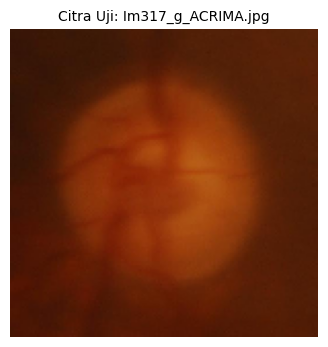

** HASIL KLASIFIKASI MODEL CNN **
Prediksi: glaucoma
Accuracy: 98.30%



In [10]:
from google.colab import files
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Asumsi:
# 1. loaded_model (model yang sudah dilatih) tersedia.
# 2. IMAGE_SIZE (150, 150) sudah didefinisikan.
# 3. class_indices (misalnya, {'Glaukoma': 0, 'Normal': 1}) sudah didefinisikan.

def test_manual_upload_glaucoma(model, target_size, class_indices):
    """
    Memungkinkan pengguna mengunggah citra secara manual untuk dideteksi glaukoma.
    """
    print("Silakan upload satu file citra fundus mata (PNG, JPG, JPEG).")
    uploaded = files.upload()

    if not uploaded:
        print("Pembatalan upload atau file tidak ditemukan.")
        return

    # Ambil nama file yang diunggah
    file_name = list(uploaded.keys())[0]

    print(f"\nMemproses file: {file_name}...")

    try:
        # 1. Load dan Pre-process Citra
        img = load_img(file_name, target_size=target_size)
        img_array = img_to_array(img)

        # 2. Normalisasi dan Persiapan Input Model
        img_array = img_array / 255.0  # Normalisasi
        img_array = np.expand_dims(img_array, axis=0) # Tambah dimensi batch (1, H, W, C)

        # 3. Prediksi
        prediction = model.predict(img_array)[0][0]

        # 4. Interpretasi Hasil

        # Mendapatkan nama kelas: membalikkan class_indices
        # Contoh: Jika class_indices adalah {'Glaukoma': 0, 'Normal': 1}
        class_map = {v: k for k, v in class_indices.items()}

        threshold = 0.5
        if prediction >= threshold:
            predicted_class = class_map[1]
            confidence = prediction * 100
            result_color = 'green'
        else:
            predicted_class = class_map[0]
            confidence = (1 - prediction) * 100
            result_color = 'red'

        # 5. Tampilkan Hasil

        # Tampilkan Citra
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title(f"Citra Uji: {file_name}", fontsize=10)
        plt.axis('off')
        plt.show()

        # Tampilkan Hasil Klasifikasi
        print("====================================")
        print(f"** HASIL KLASIFIKASI MODEL CNN **")
        print("====================================")
        print(f"Prediksi: \033[1m{predicted_class}\033[0m")
        print(f"Accuracy: {confidence:.2f}%")
        print("====================================\n")

    except Exception as e:
        print(f"Terjadi kesalahan saat memproses citra: {e}")

# =======================================================
# PANGGIL FUNGSI UNTUK MELAKUKAN UJI MANUAL
# Pastikan Anda telah menjalankan semua blok kode sebelumnya
# (Bagian I, II, dan III) agar loaded_model dan class_indices tersedia.
# =======================================================

# Contoh Panggilan (Asumsi: 'loaded_model' dan 'class_indices' sudah tersedia)
# Jika Anda menjalankan ini sebagai blok terpisah, pastikan Anda telah memuat model
# dan mendapatkan class_indices dari generator data training sebelumnya.

if 'loaded_model' in globals() and 'class_indices' in globals():
    test_manual_upload_glaucoma(loaded_model, IMAGE_SIZE, class_indices)
else:
    print("❌ ERROR: Variabel 'loaded_model' atau 'class_indices' tidak ditemukan.")
    print("Pastikan Anda sudah menjalankan Bagian III (Load Model) dan Bagian II (Load Data) sebelumnya.")